In [2]:
import pandas as pd
import micom
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.api as sm
import sklearn.metrics


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import mixedlm
from scipy.stats import wilcoxon

%matplotlib inline

## Collect Metadata

In [3]:
# Collect metadata 
metadata = pd.read_table('../Hiseq_metagenomic_202_190916 metadata_conditions.txt')

# Drop header and control rows
metadata = metadata.drop(metadata.index[[0,83,84]])

# Create dictionary with subject IDs
subject_dict = metadata.set_index('Name')['subject_id'].to_dict()
treatment_dict = metadata.set_index('Name')['treatment_group'].to_dict()

## Import qPCR Table

In [4]:
# Read Table
qPCR = pd.read_table('../qPCR/qPCR-reaction-table.tsv')
qPCR['Strain'] = qPCR['Strain'].str.replace('EHAL','AHAL')
qPCR.head()

,Treatment,Strain,Primers,Week,Subject,PassQC,PassFilter,TmExpected,TmDiff,TemperatureQpcr,Ct
0,WBF-010,AMUC,AMUC_AT,0,SS_15,False,False,83.33,NaN,NaN,37.057988
1,WBF-010,AMUC,AMUC_AT,0,SS_15,False,False,83.33,NaN,NaN,-inf
2,WBF-010,AMUC,AMUC_AT,0,SS_15,False,False,83.33,NaN,NaN,37.390592
3,WBF-010,AMUC,AMUC_AT,0,SS_15,False,False,83.33,NaN,NaN,36.151990
4,Placebo,AMUC,AMUC_AT,4,SS_5,False,False,83.33,NaN,NaN,37.475383


## Filter Table 

In [5]:
# Remove cycle threshold of -inf
qPCR_Ct = qPCR[qPCR['Ct']!= -np.inf].sort_values(by = 'Ct') 

# Remove reads that failed QC, filter
qPCR_filter = qPCR_Ct[(qPCR_Ct['PassQC'] == True)&(qPCR_Ct['PassFilter'] == True)]
# qPCR_filter = qPCR_Ct.copy()

# Remove less efficient primers for EHAL, CBEI
qPCR_filter = qPCR_filter.loc[qPCR['Primers'] != 'EHAL_AN']
qPCR_filter = qPCR_filter.loc[qPCR['Primers'] != 'CBEI_AB']

# Format column types
qPCR_filter['Week'] = qPCR_filter['Week'].astype('str')

# Sort table
qPCR_filter = qPCR_filter.sort_values(by = ['Strain','Week'])

# Rename strain abbreviations 
# qPCR_filter['Strain'] = qPCR_filter['Strain'].str.replace(
#     'AMUC','Akkermansia muciniphila').str.replace(
#     'BINF','Bifidobacterium longum').str.replace(
#     'CBEI','Clostridium beijerinckii').str.replace(
#     'CBUT','Clostridium butyricum').str.replace(
#     'EHAL','Anaerobutyricum hallii')

qPCR_filter

,Treatment,Strain,Primers,Week,Subject,PassQC,PassFilter,TmExpected,TmDiff,TemperatureQpcr,Ct
5881,Placebo,AHAL,EHAL_AH,0,SS_130,True,True,77.705,0.155,77.86,23.555805
5889,Placebo,AHAL,EHAL_AH,0,SS_130,True,True,77.705,-0.105,77.60,24.014607
5890,Placebo,AHAL,EHAL_AH,0,SS_130,True,True,77.705,-0.175,77.53,24.062299
5882,Placebo,AHAL,EHAL_AH,0,SS_130,True,True,77.705,-0.205,77.50,26.352277
6457,WBF-010,AHAL,EHAL_AH,0,SS_107,True,True,77.680,-0.080,77.60,27.561225
...,...,...,...,...,...,...,...,...,...,...,...
4417,WBF-011,CBUT,CBUT_AS,4,SS_38,True,True,74.150,-0.330,73.82,38.896977
4713,WBF-010,CBUT,CBUT_AS,4,SS_83,True,True,73.780,0.320,74.10,38.972296
5649,WBF-011,CBUT,CBUT_AS,4,SS_102,True,True,73.760,-0.330,73.43,39.538788
4659,Placebo,CBUT,CBUT_AS,4,SS_5,True,True,73.770,0.170,73.94,39.756866


## Calculate Inverse Cycle Threshold

In [6]:
# Calculate inverse
qPCR_filter['Ct_inv'] = 1/qPCR_filter['Ct']
qPCR_filter = qPCR_filter[qPCR_filter['Week']!= '16']
qPCR_filter = qPCR_filter[qPCR_filter['Treatment'] != 'WBF-010']

## Plot qPCR Data 
Plot 1/Ct across study arms for each strain and week

/tmp/ipykernel_1673384/1252777928.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1673384/1252777928.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


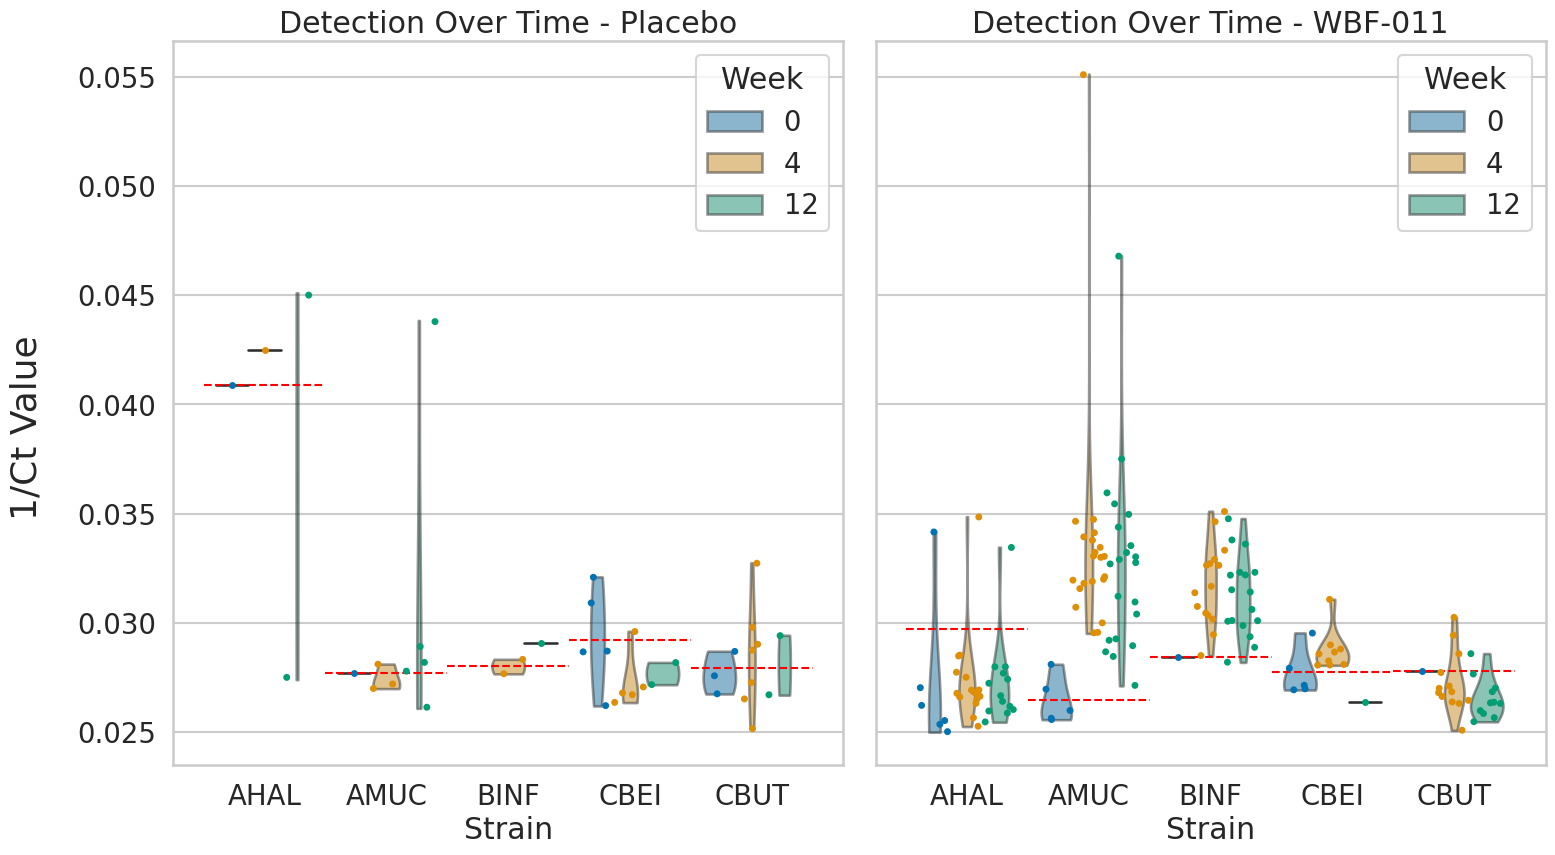

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set all styling consistently BEFORE plotting
sns.set_theme(style="whitegrid")       # Ensures white grid
sns.set_context("talk", font_scale=1.2)  # Sets all font sizes reasonably large
sns.set_palette("colorblind")          # Applies colorblind-safe palette

# Now create your plots
treatments = np.array(['Placebo', 'WBF-011'], dtype='object')
fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharey=True)

# Loop over treatments and make plots
for i, treatment in enumerate(treatments):
    ax = axes[i]

    treatment_data = qPCR_filter[qPCR_filter["Treatment"] == treatment]

    strain_thresholds = treatment_data.loc[(treatment_data['Week'] == '0')].groupby('Strain')['Ct_inv'].mean().to_dict()
    if len(strain_thresholds) < 5:
        strain_thresholds['BINF'] = 0.028

    treatment_data['threshold'] = treatment_data['Strain'].map(strain_thresholds)

    treatment_data = treatment_data.groupby(['Treatment','Strain','Week','Subject']).mean(numeric_only=True).reset_index()
    treatment_data['Week'] = treatment_data['Week'].astype(int)
    treatment_data = treatment_data.sort_values(by=['Strain','Week'])
    treatment_data['Week'] = treatment_data['Week'].astype(str)


    sns.violinplot(data=treatment_data, x="Strain", y="Ct_inv", hue="Week", 
                   split=False, alpha=0.5, inner=None, ax=ax, cut=0.01)
    sns.stripplot(data=treatment_data, x="Strain", y="Ct_inv", hue="Week", 
                  dodge=True, size=5, jitter=0.4, ax=ax, legend=False)

    ax.set(ylabel='')
    ax.set_title(f"Detection Over Time - {treatment}")

    x_positions = {strain: idx for idx, strain in enumerate(treatment_data["Strain"].unique())}
    for strain in x_positions:
        x_pos = x_positions[strain]
        ax.hlines(y=strain_thresholds[strain], xmin=x_pos - 0.5, xmax=x_pos + 0.5, 
                  color='red', linestyle='--', linewidth=1.5)

fig.supylabel('1/Ct Value')
plt.tight_layout()
plt.savefig("../figures/qPCR_threshold.svg", dpi=300, bbox_inches="tight")
plt.show()


In [199]:
scipy.stats.mannwhitneyu(pd.Series([0.028435]*17), 
                         treatment_data[(treatment_data['Strain'] == 'BINF')&(treatment_data['Week'] == '12')]['Ct_inv'])
# treatment_data[(treatment_data['Strain'] == 'BINF')&(treatment_data['Week'] == '0')]['Ct_inv']
# pd.Series([0.028435]*17)

MannwhitneyuResult(statistic=170.0, pvalue=4.794468507492326e-07)

## Mixed-Effects Model
Iterate across strains for each study arm (Placebo, WBF-010, WBF-011)

In [86]:
# Mixed effect model (random effect: Subject)
arm = 'WBF-011'
for strain in qPCR_filter.loc[qPCR_filter['Treatment'] == arm]["Strain"].unique():
    qPCR_filter['Week'] = qPCR_filter['Week'].astype('int')
    df_strain = qPCR_filter.loc[(qPCR_filter["Strain"] == strain)&(qPCR_filter['Treatment'] == arm)]  # Filter for current strain
    model = mixedlm("Ct_inv ~ Week", df_strain, groups=df_strain["Subject"]).fit()    
    print(f"\n=== Mixed Effects Model for {strain} ===")
    print(model.summary())

/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.



=== Mixed Effects Model for AMUC ===
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Ct_inv   
No. Observations: 319     Method:             REML     
No. Groups:       21      Scale:              0.0000   
Min. group size:  8       Log-Likelihood:     1337.6171
Max. group size:  22      Converged:          Yes      
Mean group size:  15.2                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.033    0.001 41.328 0.000  0.032  0.035
Week         -0.000    0.000 -1.044 0.296 -0.000  0.000
Group Var     0.000    0.001                           


=== Mixed Effects Model for BINF ===
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Ct_inv  
No. Observations: 153     Method:             REML    
No. Groups:       19      Scale:              0.

/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.



=== Mixed Effects Model for CBEI ===
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Ct_inv 
No. Observations: 18      Method:             REML   
No. Groups:       13      Scale:              0.0000 
Min. group size:  1       Log-Likelihood:     81.5084
Max. group size:  4       Converged:          Yes    
Mean group size:  1.4                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.028    0.000 97.422 0.000  0.028  0.029
Week       -0.000    0.000 -0.121 0.903 -0.000  0.000
Group Var   0.000                                    


=== Mixed Effects Model for CBUT ===
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Ct_inv  
No. Observations: 73      Method:             REML    
No. Groups:       19      Scale:              0.0000  
Min. group size:  

/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.



=== Mixed Effects Model for EHAL ===
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Ct_inv  
No. Observations: 92      Method:             REML    
No. Groups:       17      Scale:              0.0000  
Min. group size:  1       Log-Likelihood:     453.1879
Max. group size:  18      Converged:          Yes     
Mean group size:  5.4                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.027    0.001 50.231 0.000  0.026  0.029
Week        -0.000    0.000 -0.224 0.823 -0.000  0.000
Group Var    0.000    0.001                           



In [128]:
treatment_data[(treatment_data.Strain == 'BINF')&(treatment_data.Week == "12")].Ct_inv.mean()

0.0312507667968371

In [70]:
import scipy.stats
treatment_data[treatment_data.Strain == 'AMUC'].Week.value_counts()
treatment_data.Week = treatment_data.Week.astype('int')

scipy.stats.linregress(treatment_data[treatment_data.Strain == 'AMUC'].Week,
                       treatment_data[treatment_data.Strain == 'AMUC'].Ct_inv)

sol = mixedlm("Ct_inv ~ Week", treatment_data, groups=treatment_data["Subject"]).fit()    
sol.summary()

/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: Ct_inv  
No. Observations: 155     Method:             REML    
No. Groups:       21      Scale:              0.0000  
Min. group size:  2       Log-Likelihood:     626.7715
Max. group size:  11      Converged:          Yes     
Mean group size:  7.4                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.029    0.001 50.101 0.000  0.028  0.030
Week         0.000    0.000  1.460 0.144 -0.000  0.000
Group Var    0.000    0.000                           
======================================================

"""